In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!source ~/anaconda3/bin/activate hjh

In [2]:
#requirements
!conda install -c conda-forge -n hjh jupyter jupyterlab -y
!conda install -c pytorch -n hjh pytorch torchvision torchaudio -y
!conda install -c conda-forge -n hjh scikit-learn -y
!conda install -c conda-forge -n hjh tqdm ipywidgets jupyterlab_widgets -y
!conda install -c conda-forge -n hjh seaborn matplotlib -y
!conda install -c conda-forge -n hjh rdkit -y

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/ufslab223/anaconda3/envs/hjh

  added / updated specs:
    - jupyter
    - jupyterlab


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anyio-4.8.0                |     pyhd8ed1ab_0         113 KB  conda-forge
    argon2-cffi-23.1.0         |     pyhd8ed1ab_1          18 KB  conda-forge
    argon2-cffi-bindings-21.2.0|  py310h5764c6d_2          34 KB  conda-forge
    arrow-1.3.0                |     pyhd8ed1ab_1          98 KB  conda-forge
    async-lru-2.0.4            |     pyhd8ed1ab_1          15 KB  conda-forge
    attrs-24.3.0               |     pyh71513ae_0          55 KB  conda-forge
    babel-2.16.0               |     pyhd8ed1ab_1         6.2 MB  conda-forge
    beautifulsoup4-4.12.3      |     pyha770c72_1         115 KB  conda-forge


In [3]:
conda list

# packages in environment at /home/ufslab223/anaconda3/envs/hjh:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
alsa-lib                  1.2.3.2              h166bdaf_0    conda-forge
anyio                     4.8.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_1    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_2    conda-forge
arrow                     1.3.0              pyhd8ed1ab_1    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_1    conda-forge
attrs                     24.3.0             pyh71513ae_0    conda-forge
babel                     2.16.0             pyhd8ed1ab_1    conda-forge
beautifulsoup4            4.12.3             pyha770c72_1    conda-forge
blas            

In [10]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

#from utils import read_ZINC_smiles, smiles_to_onehot, partition, OneHotLogPDataSet
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [58]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_dtype(torch.float32)
    torch.set_default_device('cuda')
else:
    torch.set_default_dtype(torch.float32)
    torch.set_default_device('cpu')

# 1. Pre-Processing
In this step, smiles data is read from the ZINC.smiles file and converted to a pytorch Dataset which contain feature tensor, adjacency matrix, and logP val
ue of each molecules. A smiles string is converted to feature tensor as follows:
<img src="files/Graph_Generating_Process.png">

In [59]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list


def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [60]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 100)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

Reading Data:   0%|          | 0/100 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/100 [00:00<?, ?it/s]

# 2. Model Construction
A __GCNNet__ model is composed with __GCNBlocks__, __ReadOut__, and __Predictors__. A __GCNBlock__ is composed with several __GCNLayers__, which implements the basic feature of Graph Convolution Network's layer. A user can choose whether or not to use __batch normalization__ and __attention__ in each __GCNLayer__ and to use __(gated) skip connection__ in each __GCNBlock__. A __ReadOut__ and __Predictor__ are just the fully connected layer which converts the dimension of the layer.

__Gated Skip Connection__ and __Attention__ was implemented by by evaluating each coefficient by following equations:

$$z_i = \sigma(U_{z,1}H^{(l+1)}_i + b_{z,1} + U_{z,2}H^{(l)}_i + b_{z,2})$$

$$\alpha_{i,j} = \sigma((H_iW)C(H_jW)^T)$$

Also, __attention__ was implemented as multi-head attention, which learn multi attention matrices that generate a part of output tensor.

In [61]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [62]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [63]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [64]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [65]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [66]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [67]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [68]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, and Test

In [69]:
def train(model, device, optimizer, criterion, data_train, bar, args, lr_scheduler=None):
    epoch_train_loss = 0
    model.train()
    for i, batch in enumerate(data_train):
        list_feature = batch[0].clone().detach().to(device).float()
        list_adj = batch[1].clone().detach().to(device).float()
        list_logP = batch[2].clone().detach().to(device).float()
        list_logP = list_logP.view(-1, 1)
                
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
        bar.update(len(list_feature))
    
    if lr_scheduler:
        lr_scheduler.step()  # Update learning rate at the end of the epoch

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss


In [70]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = batch[0].clone().detach().to(device).float()
            list_adj = batch[1].clone().detach().to(device).float()
            list_logP = batch[2].clone().detach().to(device).float()
            list_logP = list_logP.view(-1,1)

            model.eval()
            list_pred_logP = model(list_feature, list_adj)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [71]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = batch[0].clone().detach().to(device).float()
            list_adj = batch[1].clone().detach().to(device).float()
            list_logP = batch[2].clone().detach().to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)

            list_pred_logP = model(list_feature, list_adj)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
        
    return mae, std, logP_total, pred_logP_total

In [72]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GCNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            generator=torch.Generator(device=device),
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          generator=torch.Generator(device=device),
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           generator=torch.Generator(device=device),
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 4. Visualization

In [73]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(index=var1, columns=var2, values='mae')
    df_std = df_result.pivot(index=var1, columns=var2, values='std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    #df_mae = df_mae.apply(pd.to_numeric, errors='coerce')
    #df_std = df_std.apply(pd.to_numeric, errors='coerce')
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [74]:
def plot_performance2(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(index=var1, columns=var2, values='mae')
    df_std = df_result.pivot(index=var1, columns=var2, values='std')
    #df_mae = df_mae[df_mae.columns].astype(float)
    #df_std = df_std[df_std.columns].astype(float)
    df_mae = df_mae.apply(pd.to_numeric, errors='coerce')
    df_std = df_std.apply(pd.to_numeric, errors='coerce')
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [75]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    

In [76]:
def plot_loss(df_result, var1, var2, ylim=10):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x.iloc[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [77]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x.iloc[0], x.iloc[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# 5. Experiment

In this experiment, hyperparamter tunning will be done to find the best hyperparameter set for the __GCN__ model with __(gated) skip conenction__ and __attention__.

# 5.1 Experiment 1. lr vs n_block

In [78]:
args.batch_size = 1024
args.lr = 0.0001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 2
args.n_layer = 2
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 64
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.num_head = 8
args.step_size = 10
args.gamma = 0.1
args.dropout = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [79]:
list_lr = [0.01, 0.001, 0.0001, 0.00001]
list_n_block = [1, 2, 3]
#list_lr = [0.001]
#list_n_block = [2]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 50000.JSON', orient='table')

  0%|          | 0/32400 [00:00<?, ?it/s]

lr:0.01/n_block:1 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.01/n_block:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.01/n_block:3 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.001/n_block:1 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.001/n_block:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.001/n_block:3 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.0001/n_block:1 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.0001/n_block:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:0.0001/n_block:3 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:1e-05/n_block:1 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:1e-05/n_block:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


lr:1e-05/n_block:3 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


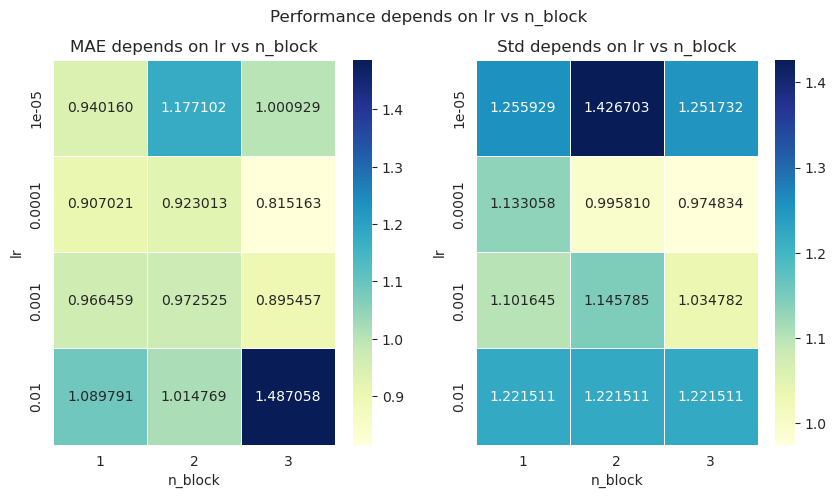

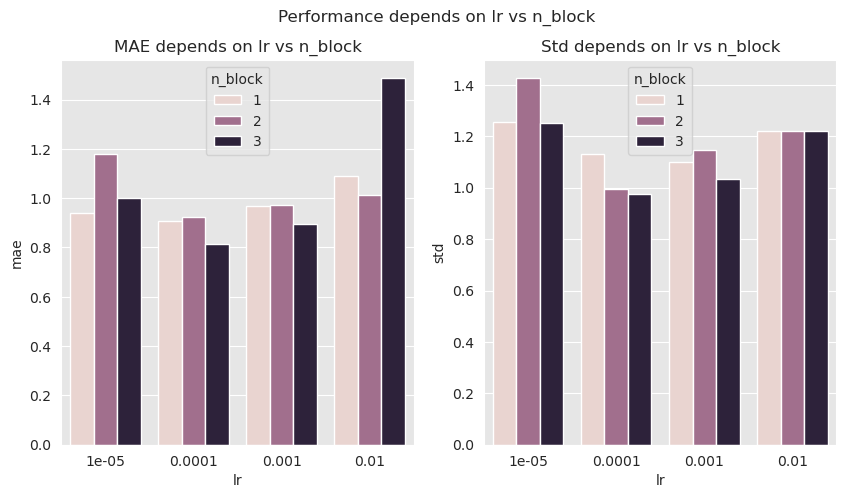

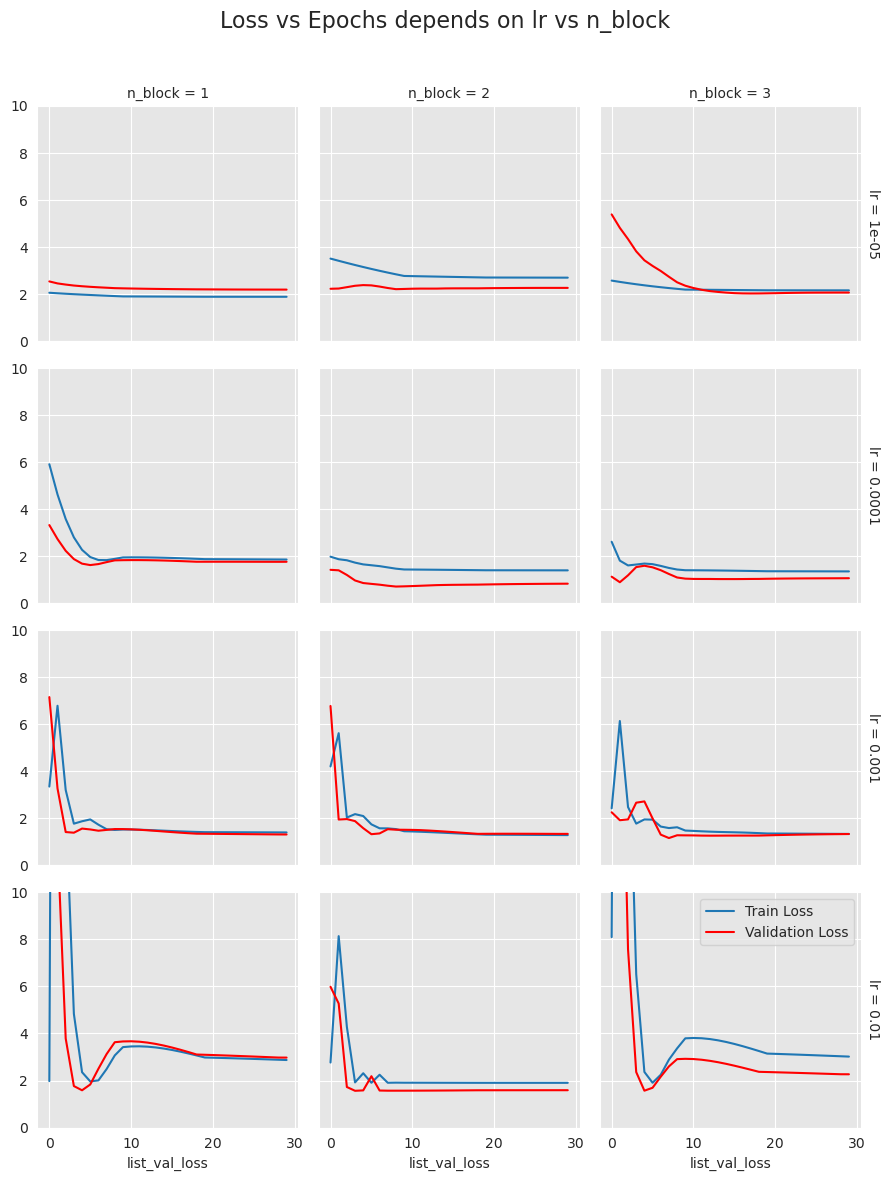

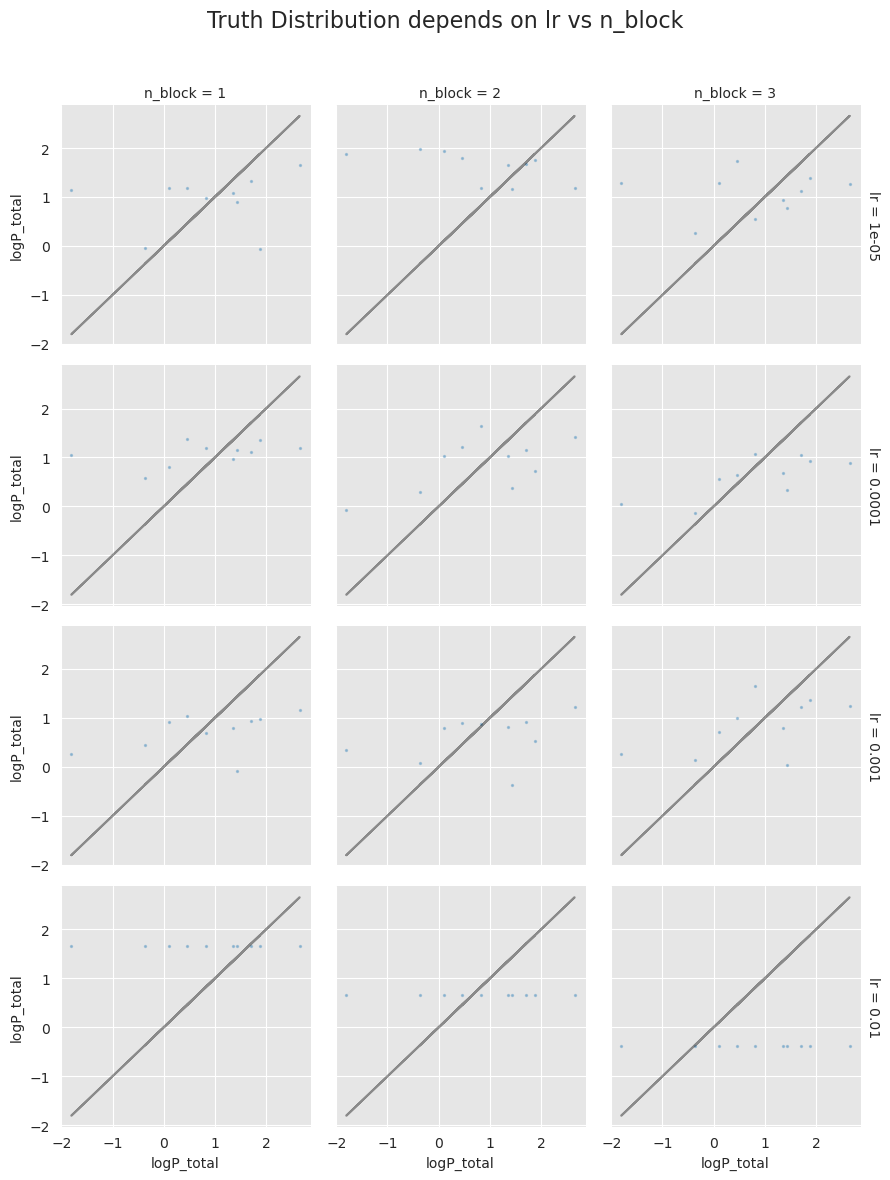

In [80]:
df_result = pd.read_json('lr vs n_block 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 1. lr vs n_block
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __learning rate (lr)__ and __number of Skip Connection Block (n_block)__ used in the each model.

The learning rate was chose to be the first hyperparameters to be tuned because if we find the best learning rate, no matter what the model architecture is, we can use that learning rate to future exepriemnts. Thus, the number of block, which effetcs the model architecture the most, was chose to be the second.
#### Variable Domain
- __lr__ : [0.01, 0.001, 0.0001, 0.00001]
- __n_block__ : [1, 2, 3]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- Learning rate of 0.001 showed the best performance.
- There was no notable tendency between the learning rate and the number of GCN blocks.
- No overfitting occured, but the models did not leanred with learning rate of 0.01.
- Time spent for training each model was not that different depending on the number of GCN blocks.

#### Discussion
- Even though there are other parameters that defines a model, such as n_layer, usage of (gated) skip connection, etc, I assumed that n_block is the most important model-defining parameter. Since learning rate of 0.001 showed the best result irrespective of n_block, I concluded that 0.001 is the optimal learning rate of all of my models.
- Model learned nothing with learning rate of 0.01. This is because the step of opimizer is too big to reach a local minimum.
- As n_block increases, time spent on training increased, but not quite 

After this experiment, the learning rate and the number of GCN blocks were fixed to 0.001 and 3, which shoed the best performance.

# Experiment 2. n_layer vs bn

In [81]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 64
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.num_head
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [82]:
list_n_layer = [1, 2, 3]
list_bn = [False, True]
var1 = "n_layer"
var2 = "bn"

dict_result = dict()
n_iter = len(list_n_layer)*len(list_bn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for n_layer in list_n_layer:
    for bn in list_bn:
        args.n_layer = n_layer
        args.bn = bn
        args.exp_name = var1+':'+str(n_layer)+'/'+var2+':'+str(bn)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_layer vs bn 50000.JSON', orient='table')

  0%|          | 0/16200 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


n_layer:1/bn:False took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


n_layer:1/bn:True took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


n_layer:2/bn:False took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


n_layer:2/bn:True took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


n_layer:3/bn:False took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


n_layer:3/bn:True took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


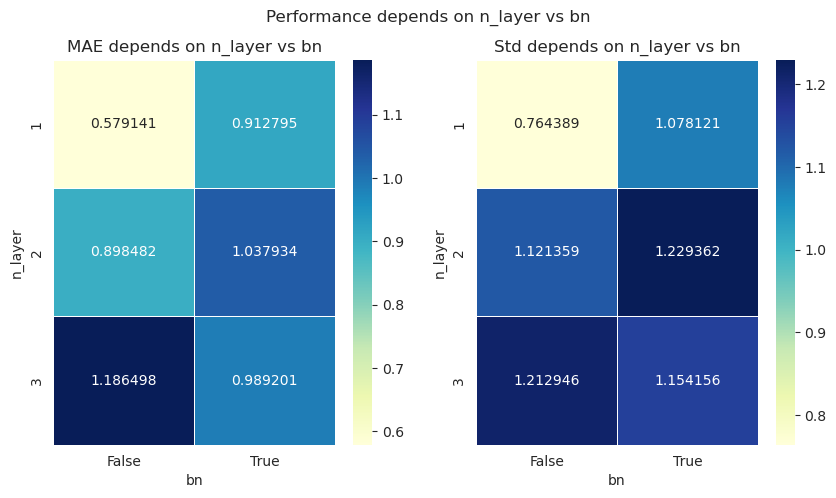

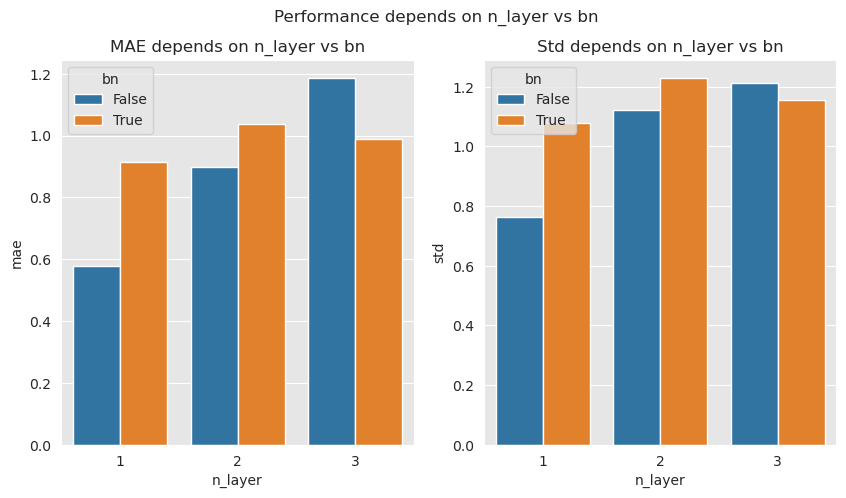

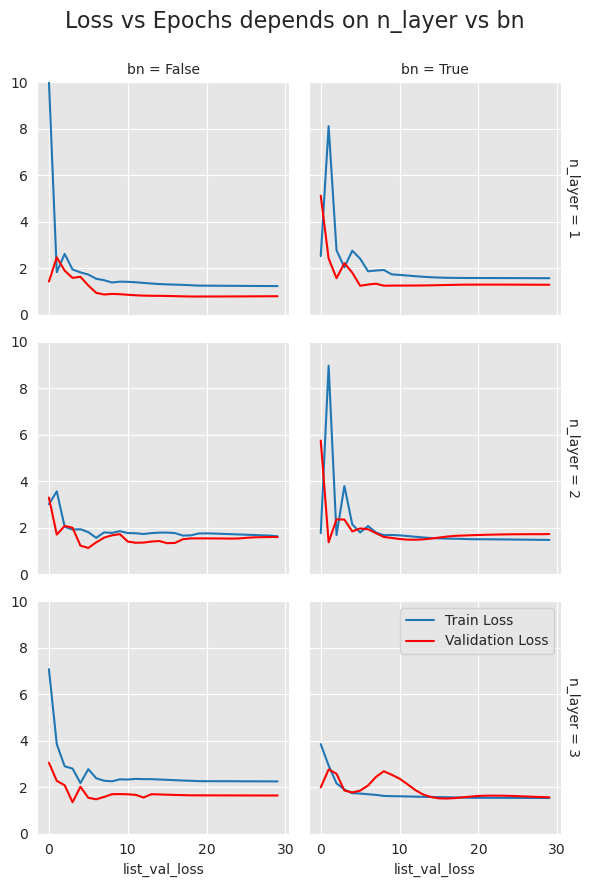

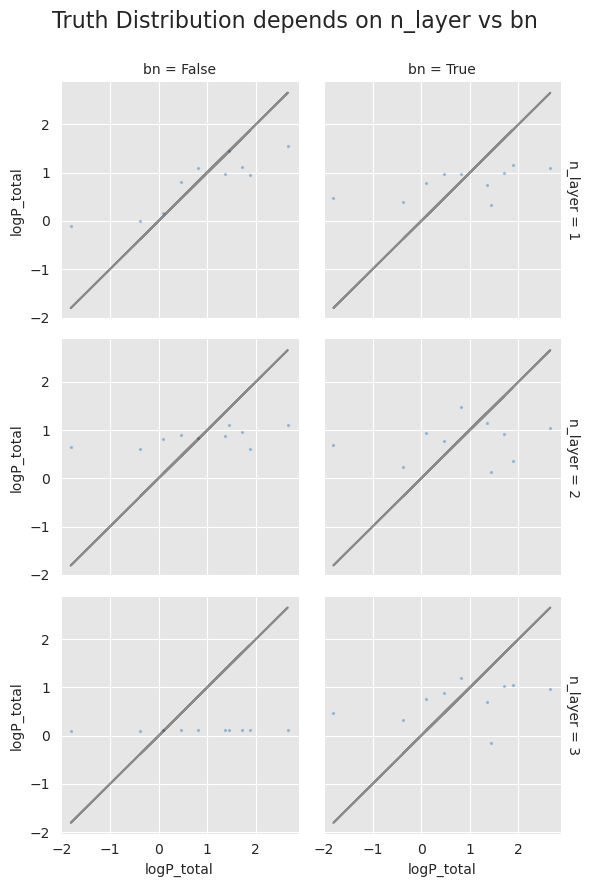

In [83]:
df_result = pd.read_json('n_layer vs bn 50000.JSON', orient='table')

plot_performance2(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 2. n_layer vs bn
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __number of layers in each block (n_layer)__ and __usage of batch normalization (bn)__ for each model.

#### Variable Domain
- __n_layer__ : [1, 2, 3]
- __bn__ : [True, False]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- Multi-layer model without batch normalization leanred nothing.
- Models with batch normalization showed better performance than models with out batch normalization.
- As the number of layer decreases, the performance increased.
- There was an unstableness in loss degradation for some models.

#### Discussion
- Maybe there is an error for the multi-layer model without batch normalization, but I couldn't find it.
- Not as expected, model with less layer showed better performance. One layer model might enough to solve the logP predicting problem.
- Unstableness of loss degradation occured in some models but vanished after epoch of 10. This is because the lr scheduler decreased the learning rate.
- As expected, batch normalization increased the performance of the model.

After this experiment, the number of layer and usage of batch normalization were set to 1 and True, which showed the best result.

# Experiment 3. sc vs atn

In [84]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.num_head = 8
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [85]:
list_sc = ['no', 'sc', 'gsc']
list_atn = [False, True]
var1 = "sc"
var2 = "atn"

dict_result = dict()
n_iter = len(list_sc)*len(list_atn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for sc in list_sc:
    for atn in list_atn:
        args.sc = sc
        args.atn = atn
        args.exp_name = var1+':'+str(sc)+'/'+var2+':'+str(atn)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('sc vs atn 50000.JSON', orient='table')

  0%|          | 0/16200 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


sc:no/atn:False took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


sc:no/atn:True took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


sc:sc/atn:False took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


sc:sc/atn:True took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


sc:gsc/atn:False took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


sc:gsc/atn:True took 1seconds.


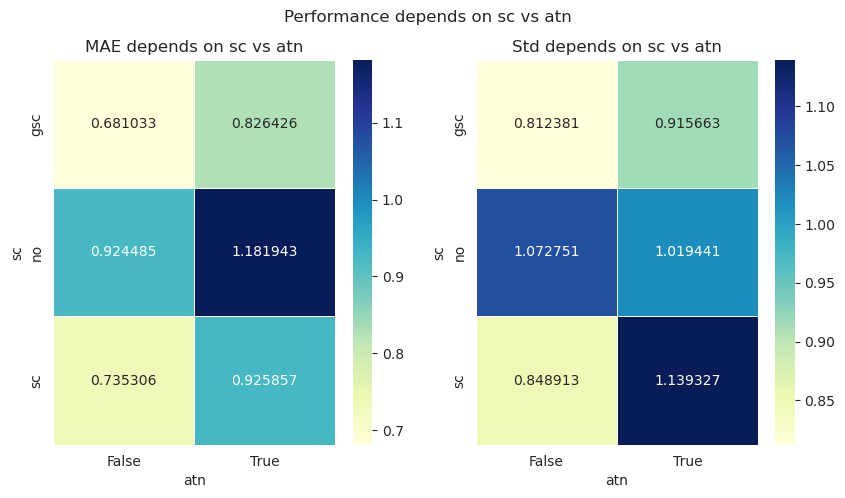

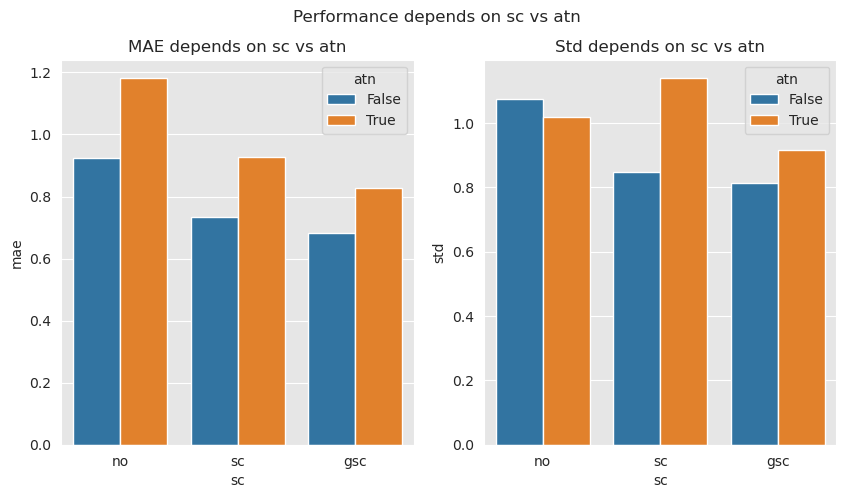

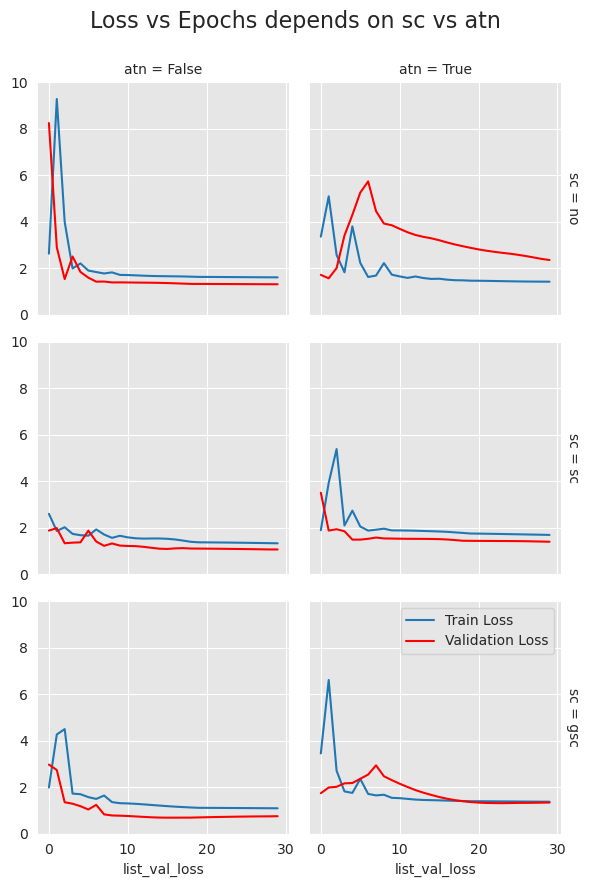

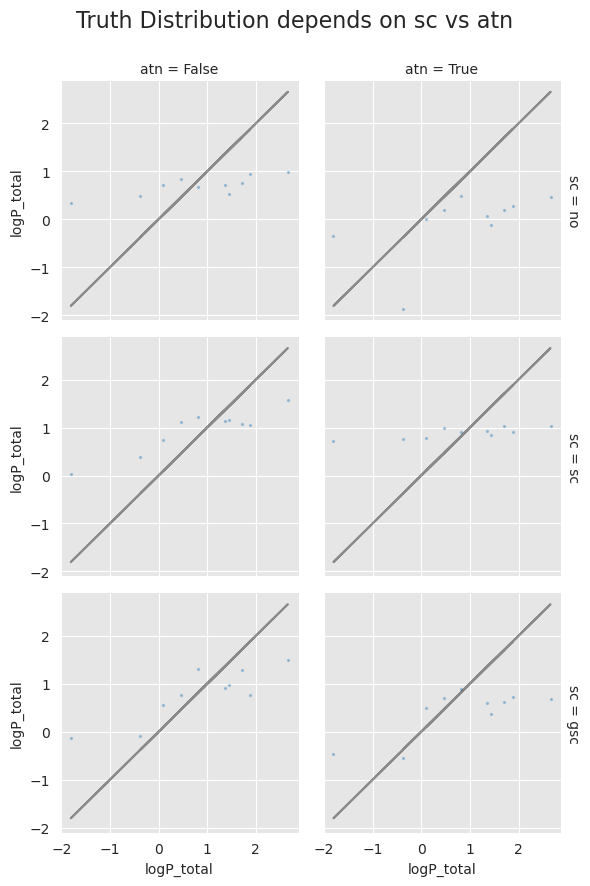

In [86]:
df_result = pd.read_json('sc vs atn 50000.JSON', orient='table')

plot_performance2(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 3. sc vs atn
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __usage of (gated) skip connection (sc)__ and __usage of attention (atn)__ for each model.

#### Variable Domain
- __sc__ : ['no', 'sc', 'gsc']
- __atn__ : [True, False]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule.

depending on the two variables.

#### Notable Results
- Both (gated) skip connection and attention improved the performance of the model.
- Model with attention took 3 times more time to be trained then model without attention.

#### Discussion
- As expected, (gated) skip connection and attention improved the performace of the model, even though it took 3 times more time.

After this experiment, the usage of (gated) skip connection and usage of attention were set to 'gsc' and True, which showed the best result.

# Experiment 4. hidden_dim vs num_head

In [87]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 8
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [88]:
list_hidden_dim = [64, 128, 256, 512]
list_num_head = [2, 4, 8, 16]
var1 = "hidden_dim"
var2 = "num_head"

dict_result = dict()
n_iter = len(list_hidden_dim)*len(list_atn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for hidden_dim in list_hidden_dim:
    for num_head in list_num_head:
        args.hidden_dim = hidden_dim
        args.num_head = num_head
        args.exp_name = var1+':'+str(hidden_dim)+'/'+var2+':'+str(num_head)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('hidden_dim vs num_head 50000.JSON', orient='table')

  0%|          | 0/21600 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:64/num_head:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:64/num_head:4 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:64/num_head:8 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:64/num_head:16 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:128/num_head:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:128/num_head:4 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:128/num_head:8 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:128/num_head:16 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:256/num_head:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:256/num_head:4 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:256/num_head:8 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:256/num_head:16 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:512/num_head:2 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:512/num_head:4 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:512/num_head:8 took 0seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


hidden_dim:512/num_head:16 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


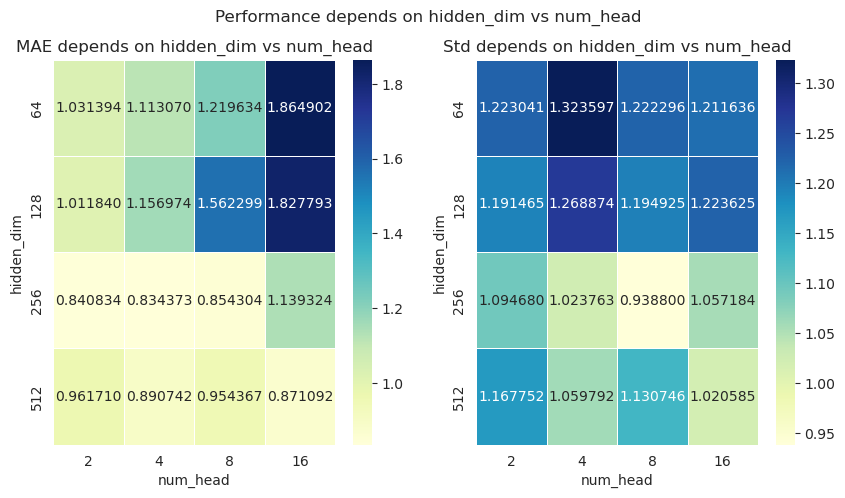

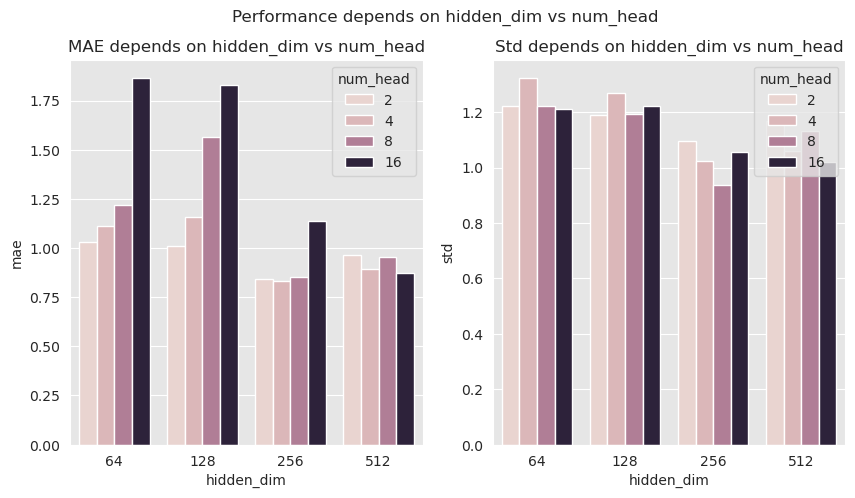

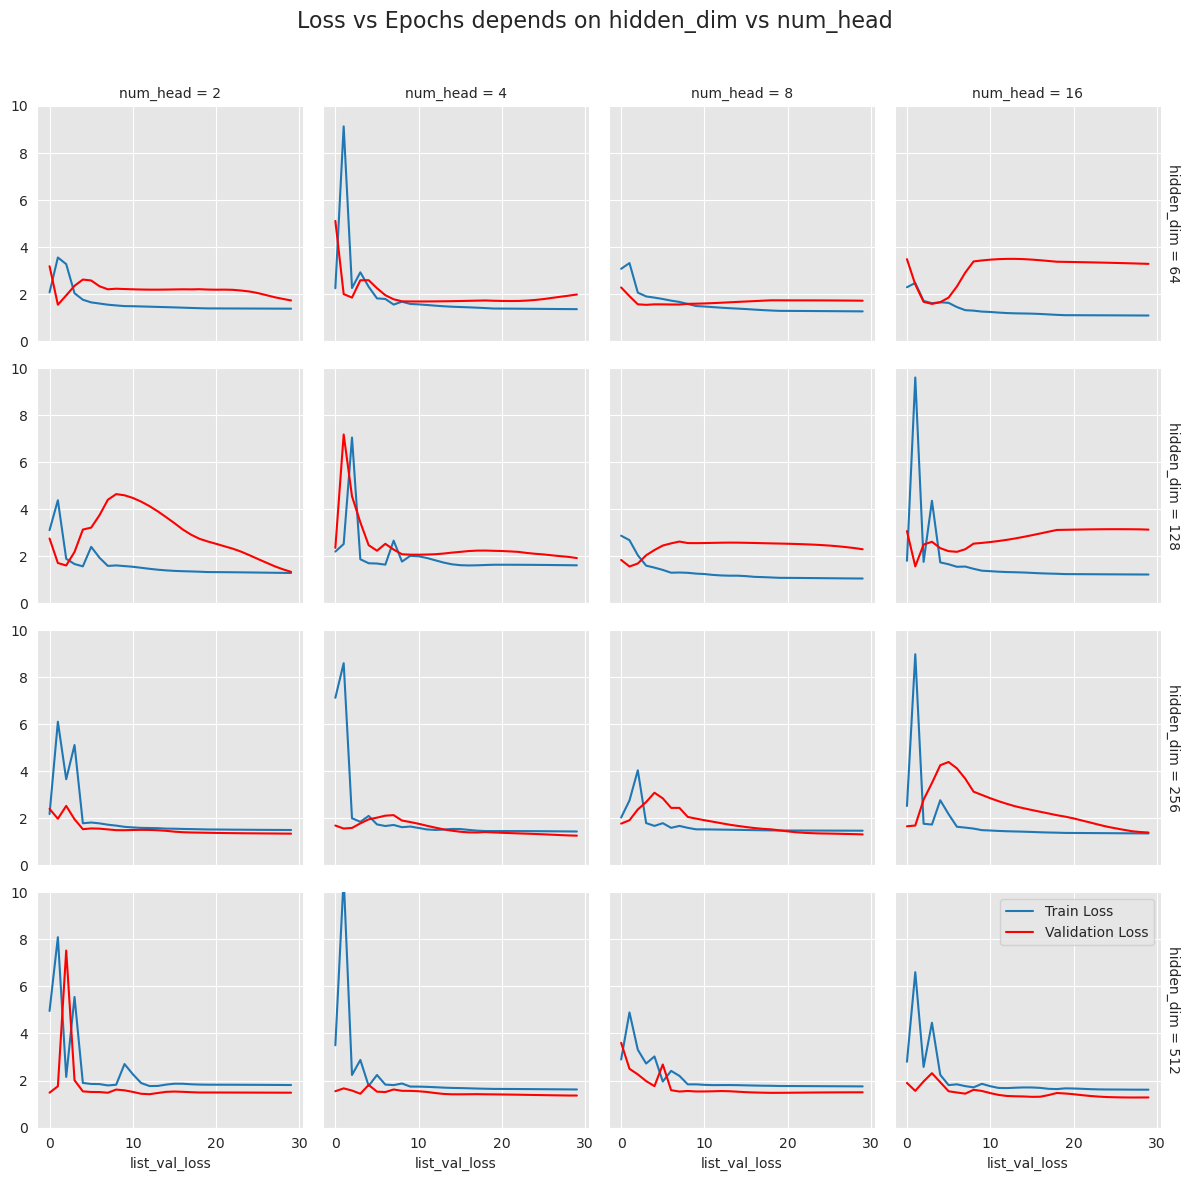

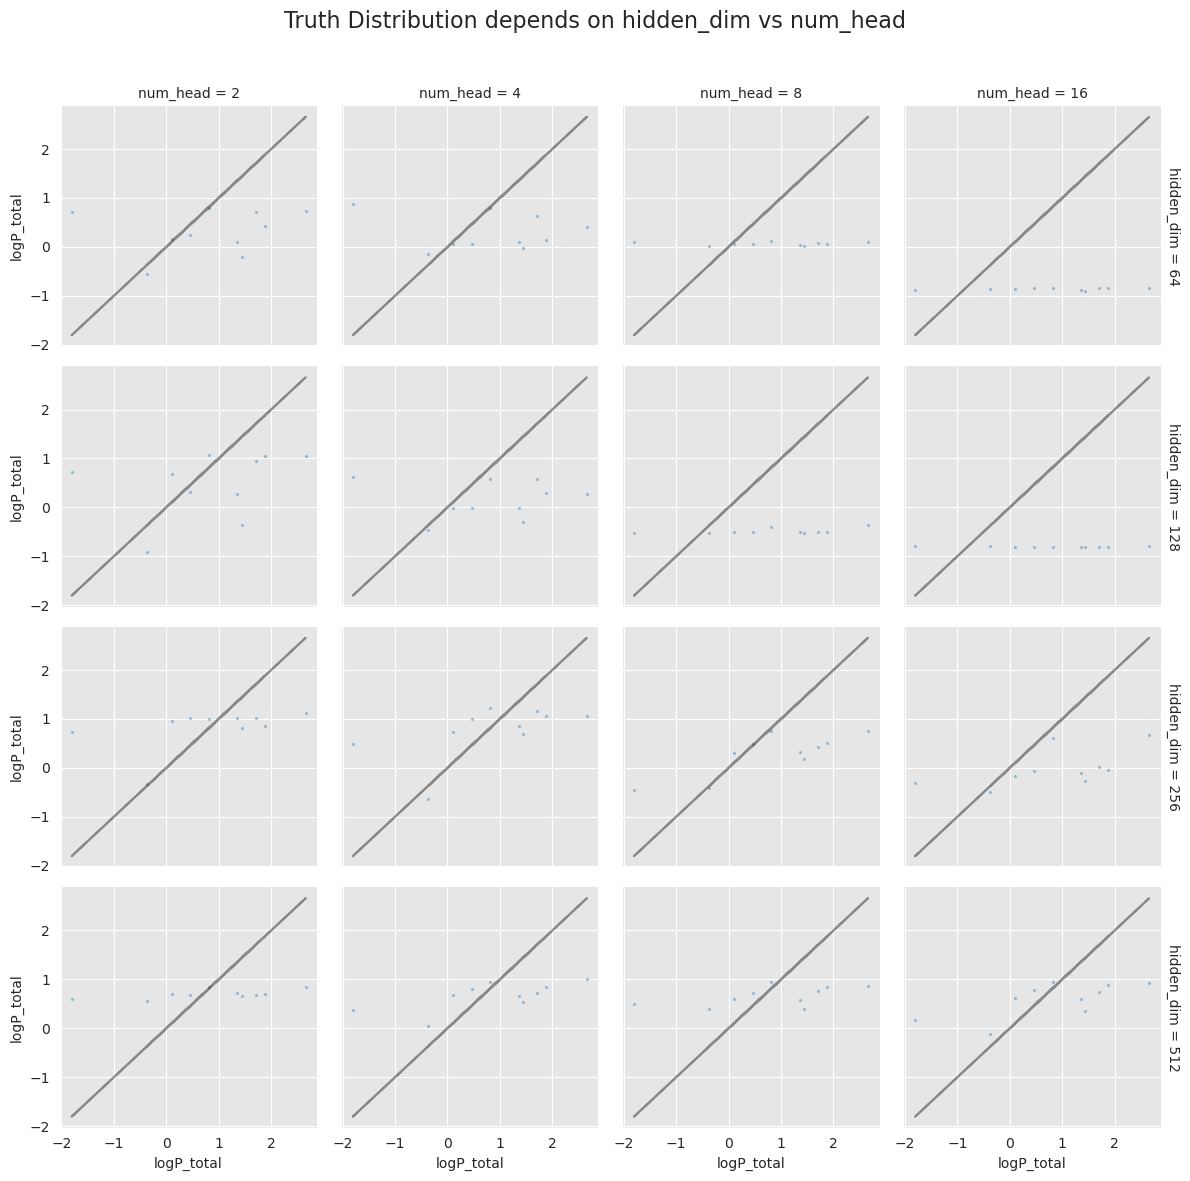

In [89]:
df_result = pd.read_json('hidden_dim vs num_head 50000.JSON', orient='table')

plot_performance2(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 4. hidden_dim vs num_head
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __hidden dimension in graph convolution layer (hidden_dim)__ and __number of attention head (num_head)__ for each model.

#### Variable Domain
- __hidden_dim__ : [64, 128, 256, 512]
- __num_head__ : [2, 4, 8, 16]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule.

depending on the two variables.

#### Notable Results
- If the value of hidden_dim/num_head is too large or too small, the model showed poor performance.

#### Discussion
- There was a tendency that as the value of hidden_dim/num_head approaches 16, the model showed better performance. Since the value of hidden_dim/num_head represents the number of paramters each head takes, there might be an optimal number of parameter that an attention head can handle.

After this experiment, the hidden dimension in graph convolution layer and the number of attention head is fixed to 256 and 16, which showed the best result.

# Experiment 5. pred_dim2 vs pred_dim3

In [90]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [91]:
list_pred_dim2 = [64, 128, 256]
list_pred_dim3 = [64, 128, 256]
var1 = "pred_dim2"
var2 = "pred_dim3"

dict_result = dict()
n_iter = len(list_pred_dim2)*len(list_pred_dim3)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for pred_dim2 in list_pred_dim2:
    for pred_dim3 in list_pred_dim3:
        args.pred_dim2 = pred_dim2
        args.pred_dim3 = pred_dim3
        args.exp_name = var1+':'+str(pred_dim2)+'/'+var2+':'+str(pred_dim3)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('pred_dim2 vs pred_dim3 50000.JSON', orient='table')

  0%|          | 0/24300 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:64/pred_dim3:64 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:64/pred_dim3:128 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:64/pred_dim3:256 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:128/pred_dim3:64 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:128/pred_dim3:128 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:128/pred_dim3:256 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:256/pred_dim3:64 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:256/pred_dim3:128 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


pred_dim2:256/pred_dim3:256 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


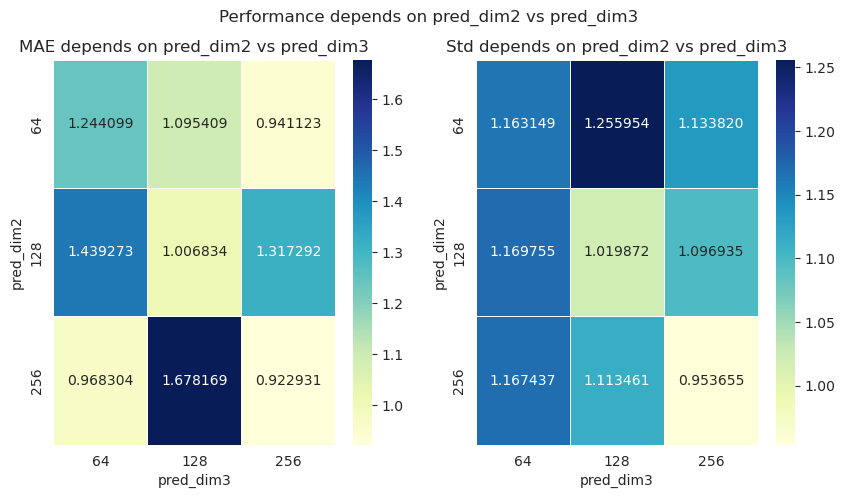

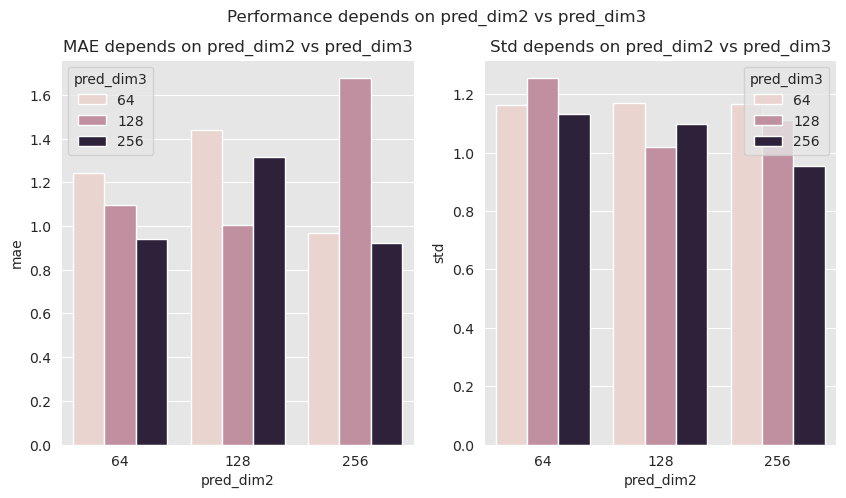

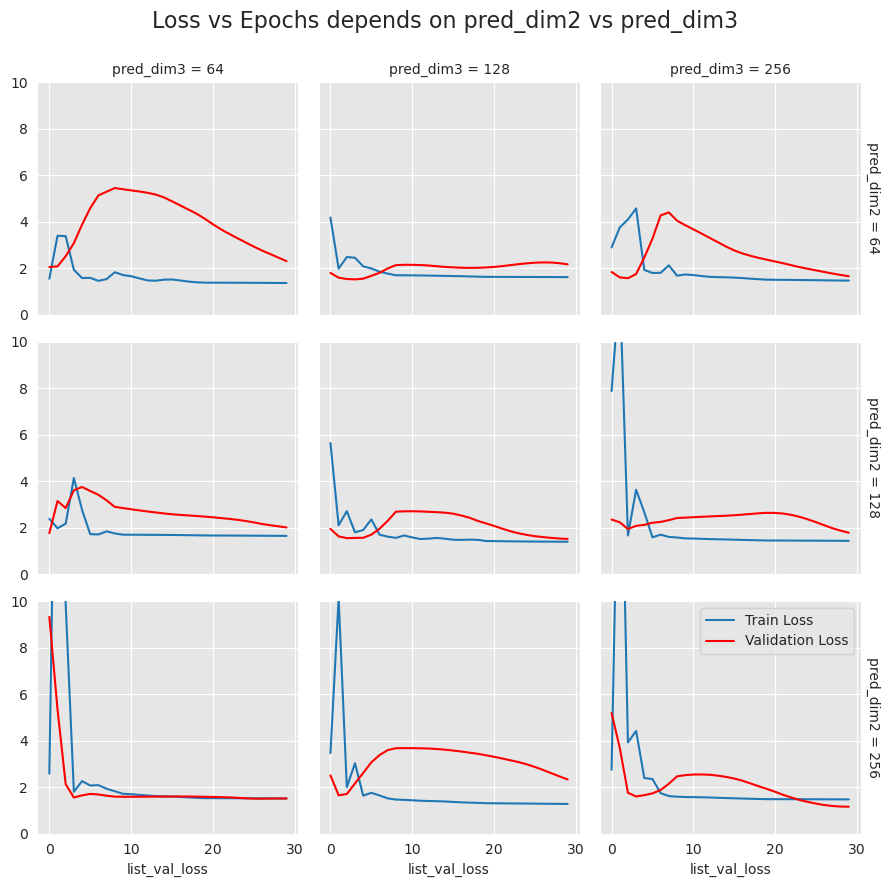

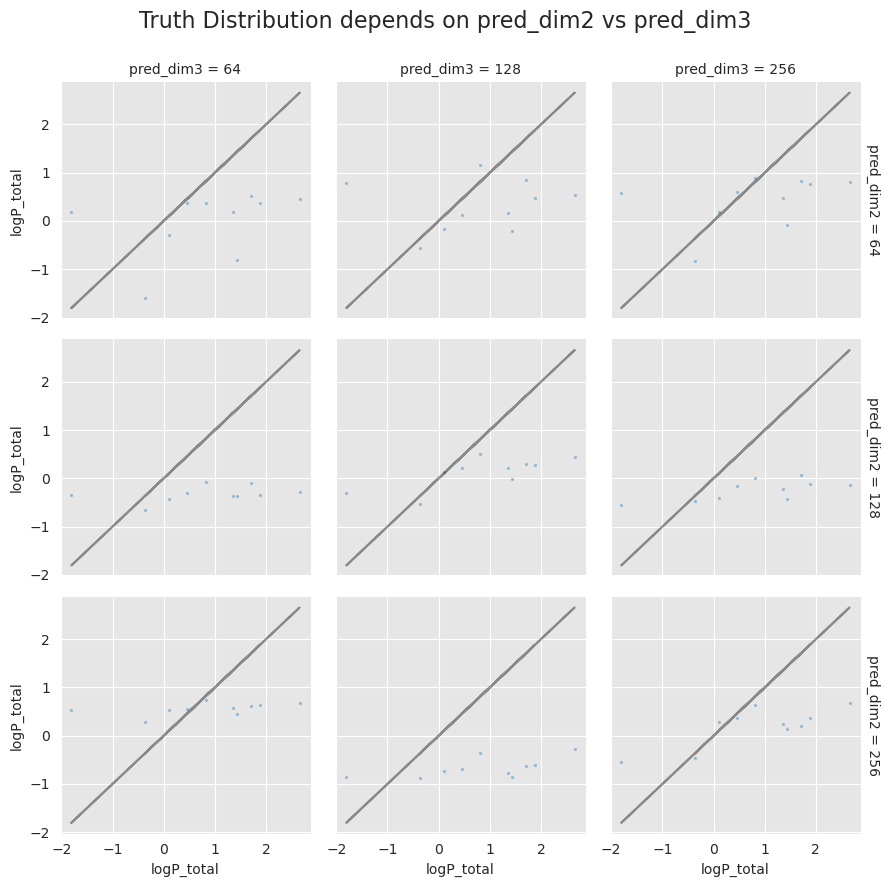

In [92]:
df_result = pd.read_json('pred_dim2 vs pred_dim3 50000.JSON', orient='table')

plot_performance2(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

## Experiment 5. pred_dim2 vs pred_dim3
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __dimension of second predictor (pred_dim2)__ and __dimesion of third predictor (pred_dim3)__ for each model.

#### Variable Domain
- __pred_dim2__ : [64, 128, 256]
- __pred_dim3__ : [64, 128, 256]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule.

depending on the two variables.

#### Notable Results
- There are no notable relation between the predictor dimensions and the mae value.
- Std value decreases as dimension of third predictor increases, and it was best at (128, 256)

#### Discussion
- Usally, the preidctor dimensions decreases as it approches the output layer in common models. However, with fixed dimension of second predictor, third predictor with larger dimension performed sligthly better. There might be no certain rule to set predictor dimensions.

After this experiment, the second and third predictor dimensions were fixed to 128, which are the mean value.


# Experiment 6. l2_coef vs dropout

In [93]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [94]:
list_l2_coef = [0.01, 0.001, 0.0001, 0]
list_dropout = [0, 0.1, 0.2, 0.3]
var1 = "l2_coef"
var2 = "dropout"

dict_result = dict()
n_iter = len(list_l2_coef)*len(list_dropout)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for l2_coef in list_l2_coef:
    for dropout in list_dropout:
        args.l2_coef = l2_coef
        args.dropout = dropout
        args.exp_name = var1+':'+str(l2_coef)+'/'+var2+':'+str(dropout)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('l2_coef vs dropout 50000.JSON', orient='table')

  0%|          | 0/43200 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


l2_coef:0.01/dropout:0 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.01/dropout:0.1 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.01/dropout:0.2 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.01/dropout:0.3 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


l2_coef:0.001/dropout:0 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.001/dropout:0.1 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.001/dropout:0.2 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.001/dropout:0.3 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


l2_coef:0.0001/dropout:0 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.0001/dropout:0.1 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.0001/dropout:0.2 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0.0001/dropout:0.3 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


l2_coef:0/dropout:0 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0/dropout:0.1 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0/dropout:0.2 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d inste

l2_coef:0/dropout:0.3 took 1seconds.


/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


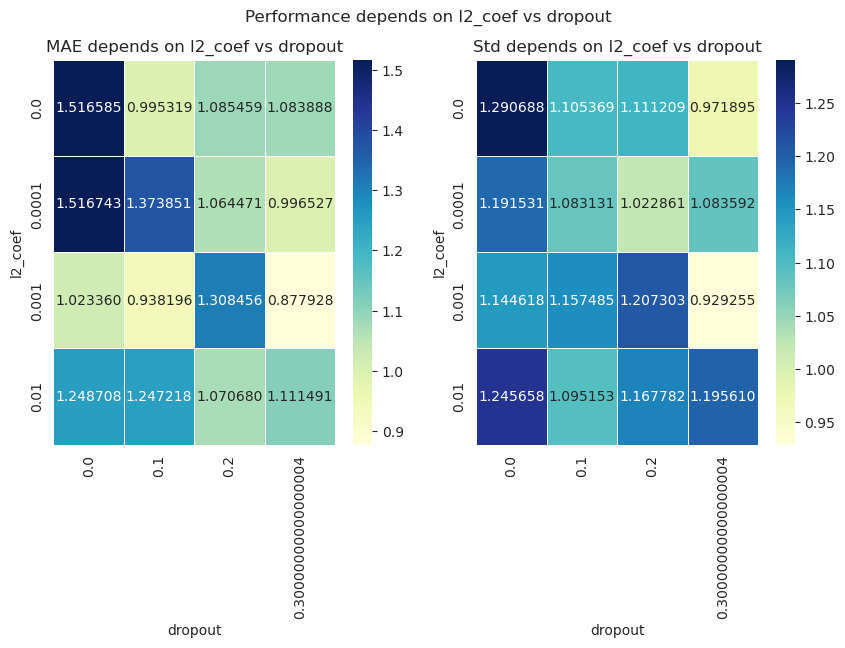

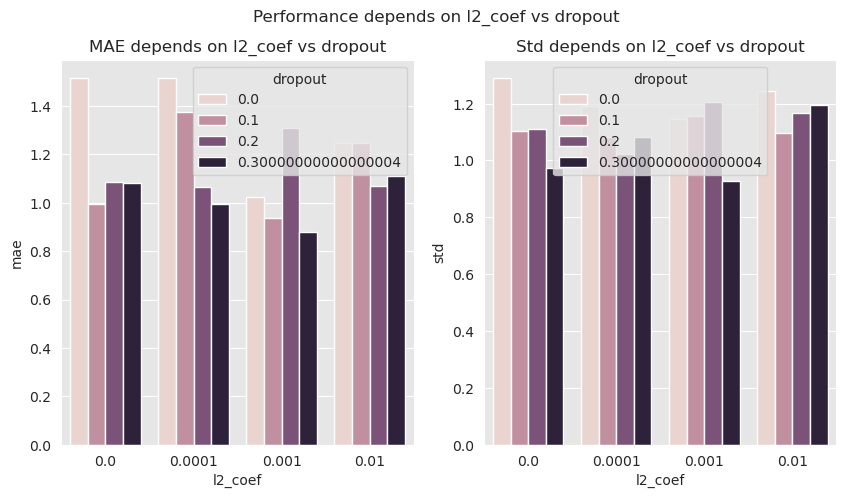

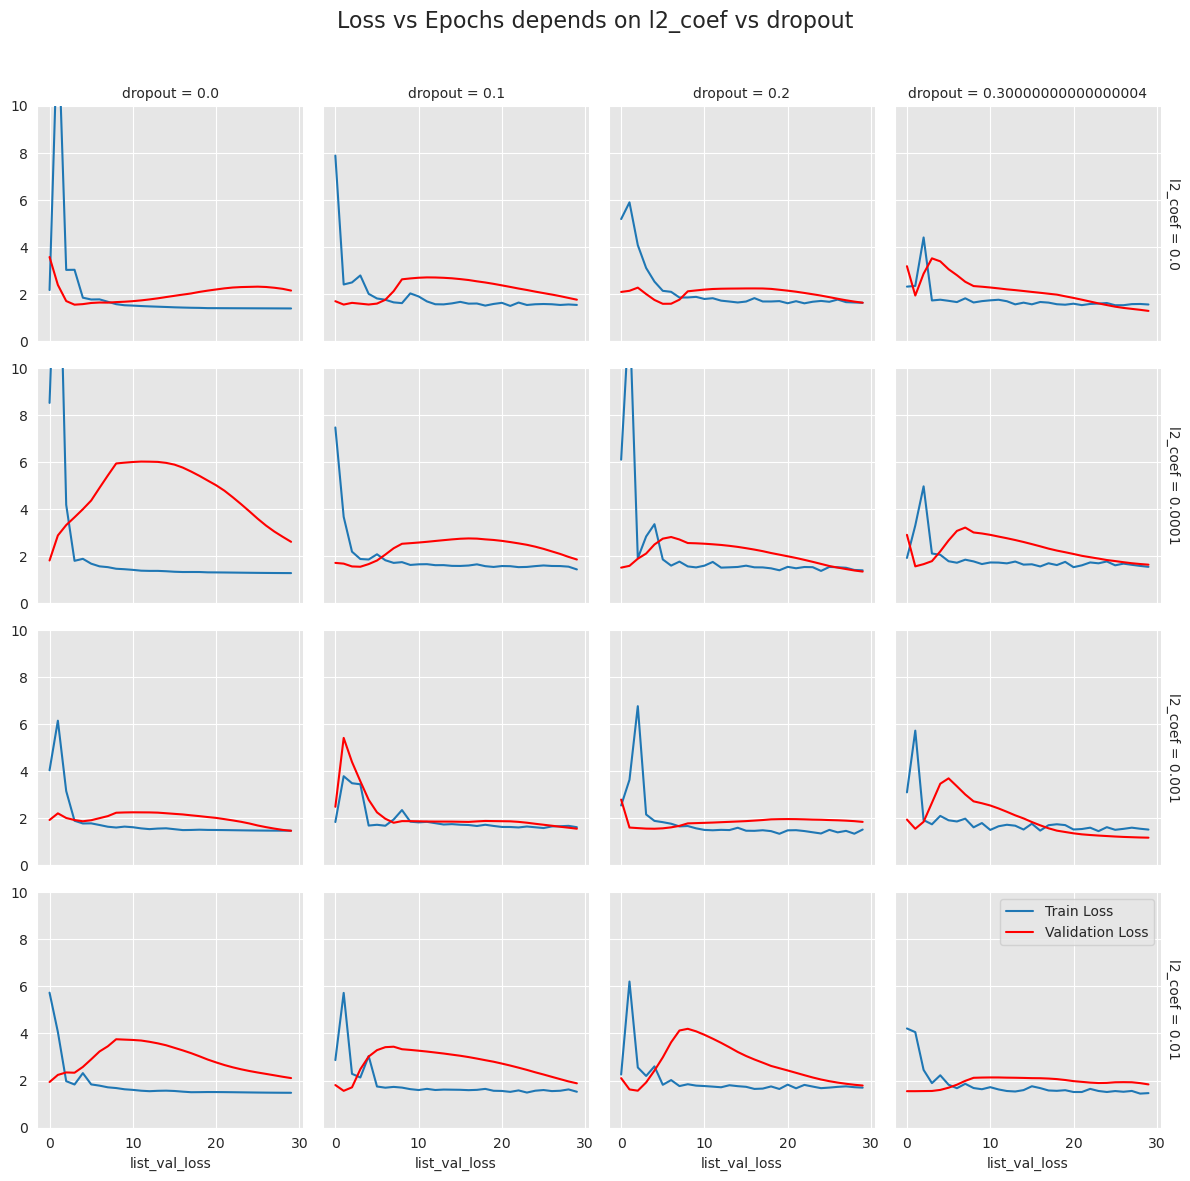

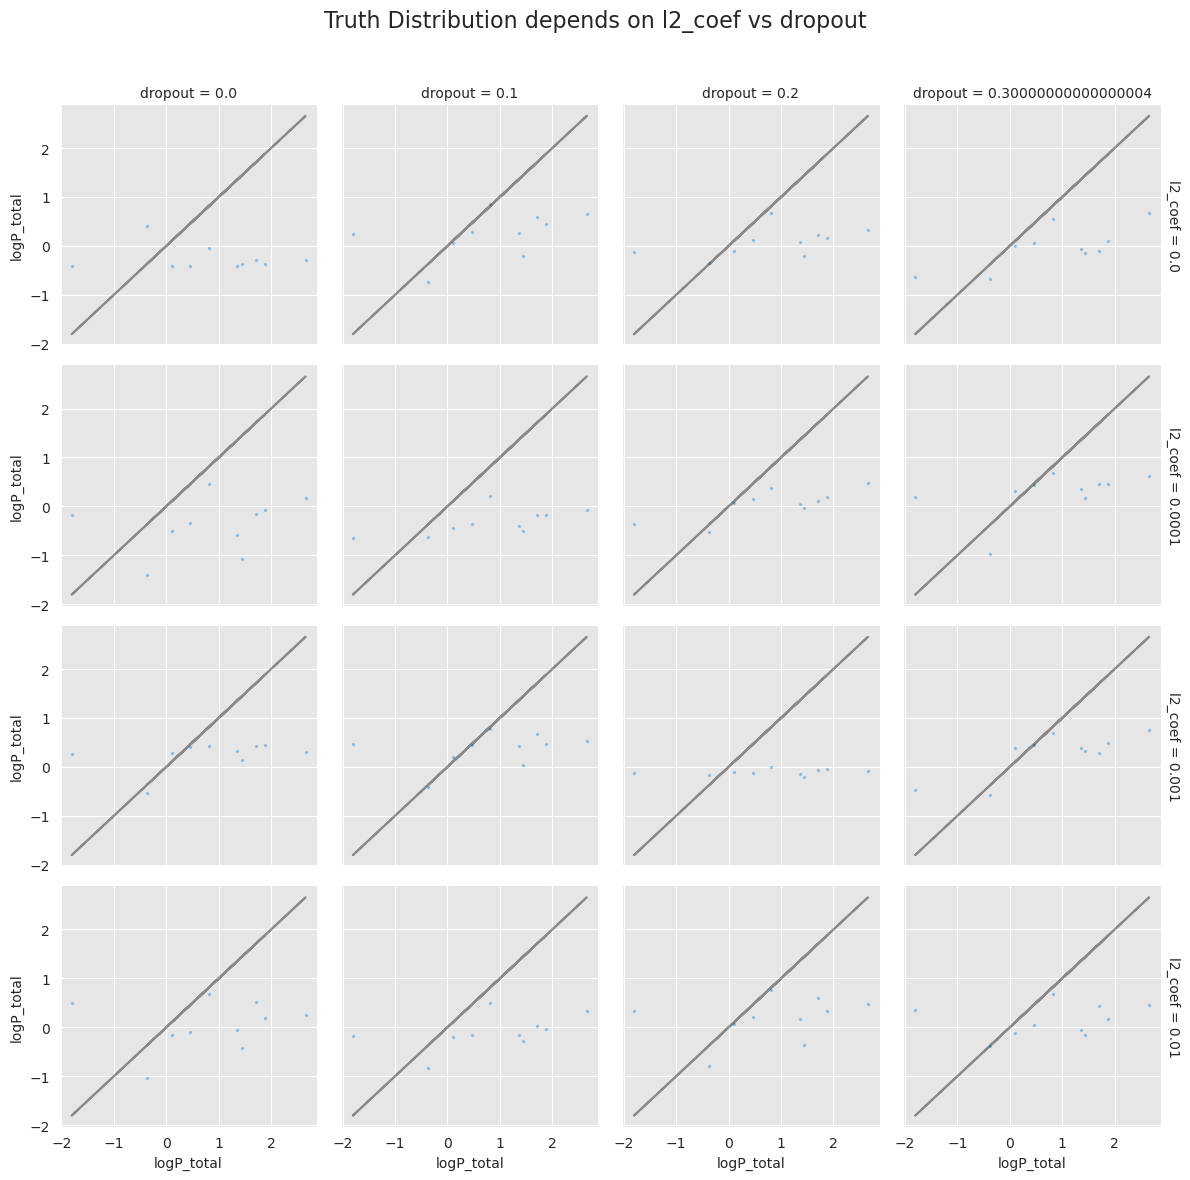

In [95]:
df_result = pd.read_json('l2_coef vs dropout 50000.JSON', orient='table')

plot_performance2(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 10)
plot_distribution(df_result, var1, var2)

## Experiment 6. l2_coef vs dropout
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __l2 coefficient (l2_coef)__ and __dropout rate (dropout)__ for each model.

#### Variable Domain
- __l2_coef__ : [0, 0.0001, 0.001, 0.01]
- __dropout__ : [0, 0.1, 0.2, 0.3]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule.

depending on the two variables.

#### Notable Results
- There was no notable realtion between the dropout rate and the performance.
- Performance got better as the l2 coefficient decreases.
- The best performance was shown from model without dropout and l2 regularization.

#### Discussion
- Not only from this experiment, there was no sign of overfitting from every experiment. Thus no regularizations such as l2 regularization and dropout is needed.
- However, there was gap between train and validation loss from the best performance experiement couducted after this experiment. To consider overfitting, epoch might be set to more than 10.

After this experiment, the l2 coefficient and dropout rate set to zero, which showed the best result.

# 6. Best performance
In this expeirment, the model with tunned hyperparamter set will be trained by 190000 data with 100 epochs to get the best performance with CNN model.

In [96]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 1000) # 1000 -> 190000 바꾸기
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

Reading Data:   0%|          | 0/1000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/1000 [00:00<?, ?it/s]

In [97]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [98]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 1000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 1000.JSON', orient='table')

  0%|          | 0/90000 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


MAE: 0.6106179912
Std: 0.8057185475


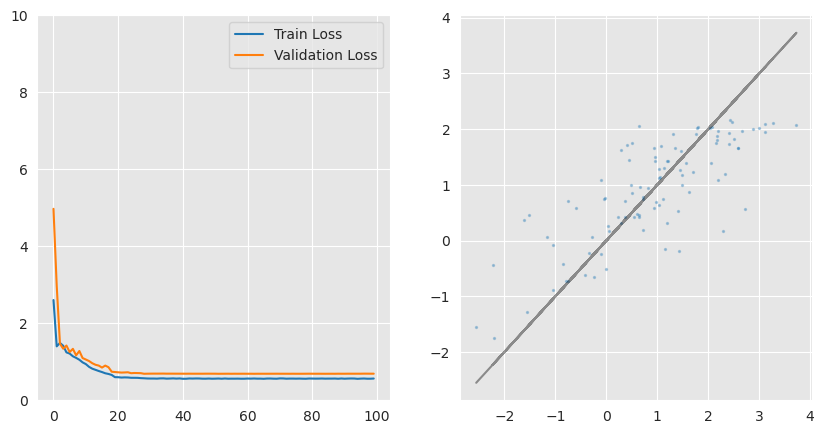

In [99]:
df_result = pd.read_json('result 1000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 10])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)

In [101]:
# with more datas maybe 10,000
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 10000) # 10000 -> 190000 바꾸기
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

Reading Data:   0%|          | 0/10000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/10000 [00:00<?, ?it/s]

In [102]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 10000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 10000.JSON', orient='table')

  0%|          | 0/900000 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


MAE: 0.09097041930000001
Std: 0.1389528804


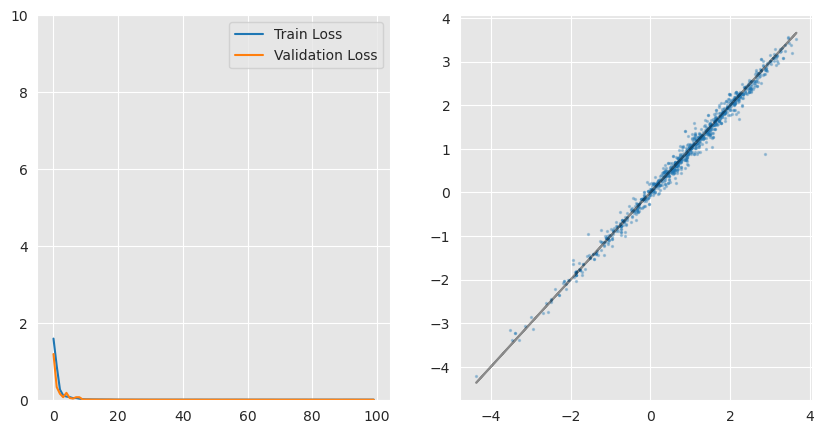

In [103]:
df_result = pd.read_json('result 10000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 10])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)

In [104]:
# 190000 개도 도전...!
# with more datas maybe 190,000
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 190000)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

Reading Data:   0%|          | 0/190000 [00:00<?, ?it/s]

Converting to Graph:   0%|          | 0/190000 [00:00<?, ?it/s]

In [105]:
dict_result = dict()
n_iter = args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')

  0%|          | 0/17100000 [00:00<?, ?it/s]

/home/ufslab223/anaconda3/envs/hjh/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


MAE: 0.09097041930000001
Std: 0.1389528804


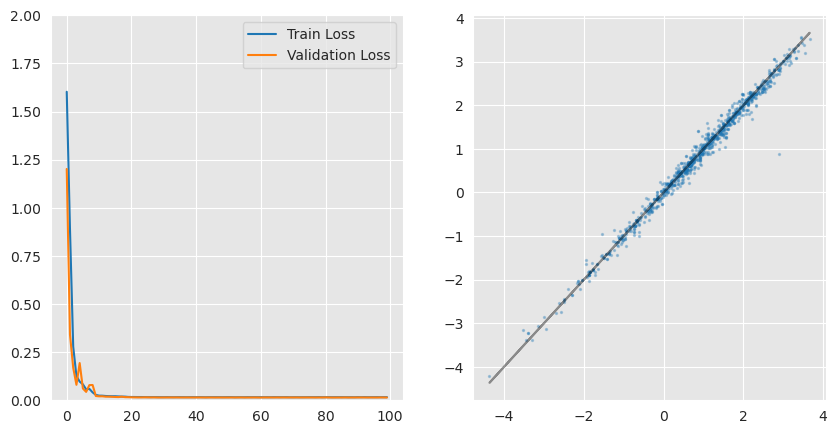

In [106]:
df_result = pd.read_json('result 10000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 2])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)